# X-ray Images (Pneumonia) Classification

#### Context
This project aims to assist clinicians to save time in diagnosing pneumonia from chext x-ray result by using the power of machine learning.

#### Content
The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

The dataset is taken from https://data.mendeley.com/datasets/rscbjbr9sj/2

In [1]:
# activate gpu environment
import os

os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [2]:
# check if tensorflow detects the gpu device
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

C:\Users\a\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7597136163396657421
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 1749391771
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14628568364910716451
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [62]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import plot_confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, Sequential, metrics, optimizers

In [4]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [5]:
tf.test.is_built_with_cuda()

True

## 1. Exploratory Data Analysis (EDA) and Data Pre-processing

In [6]:
# set directory to train, validation and test data
train_dir = 'train'
val_dir = 'val'
test_dir = 'test'

train_normal_dir = os.path.join(train_dir, 'normal')
train_pneumonia_dir = os.path.join(train_dir, 'pneumonia')

val_normal_dir = os.path.join(val_dir, 'normal')
val_pneumonia_dir = os.path.join(val_dir, 'pneumonia')

test_normal_dir = os.path.join(test_dir, 'normal')
test_pneumonia_dir = os.path.join(test_dir, 'pneumonia')

In [7]:
# check the no of class composition
train_no = len(os.listdir(train_normal_dir)) + len(os.listdir(train_pneumonia_dir))
val_no = len(os.listdir(val_normal_dir)) + len(os.listdir(val_pneumonia_dir))
test_no = len(os.listdir(test_normal_dir)) + len(os.listdir(test_pneumonia_dir))

print('No of training sample :', train_no)
print('No of validation sample :', val_no)
print('No of test sample :', test_no)

normal_no = len(os.listdir(train_normal_dir)) + len(os.listdir(val_normal_dir)) + len(os.listdir(test_normal_dir))
pneumonia_no = len(os.listdir(train_pneumonia_dir)) + len(os.listdir(val_pneumonia_dir)) + len(os.listdir(test_pneumonia_dir))

print('')
print('No of total normal sample :', normal_no)
print('No of total pneumonia sample :', pneumonia_no)

print('')
print('No of training normal sample :', len(os.listdir(train_normal_dir)))
print('No of training pneumonia sample :', len(os.listdir(train_pneumonia_dir)))

print('')
print('No of validation normal sample :', len(os.listdir(val_normal_dir)))
print('No of validation pneumonia sample :', len(os.listdir(val_pneumonia_dir)))

print('')
print('No of test normal sample :', len(os.listdir(test_normal_dir)))
print('No of test pneumonia sample :', len(os.listdir(test_pneumonia_dir)))

No of training sample : 5216
No of validation sample : 16
No of test sample : 624

No of total normal sample : 1583
No of total pneumonia sample : 4273

No of training normal sample : 1341
No of training pneumonia sample : 3875

No of validation normal sample : 8
No of validation pneumonia sample : 8

No of test normal sample : 234
No of test pneumonia sample : 390


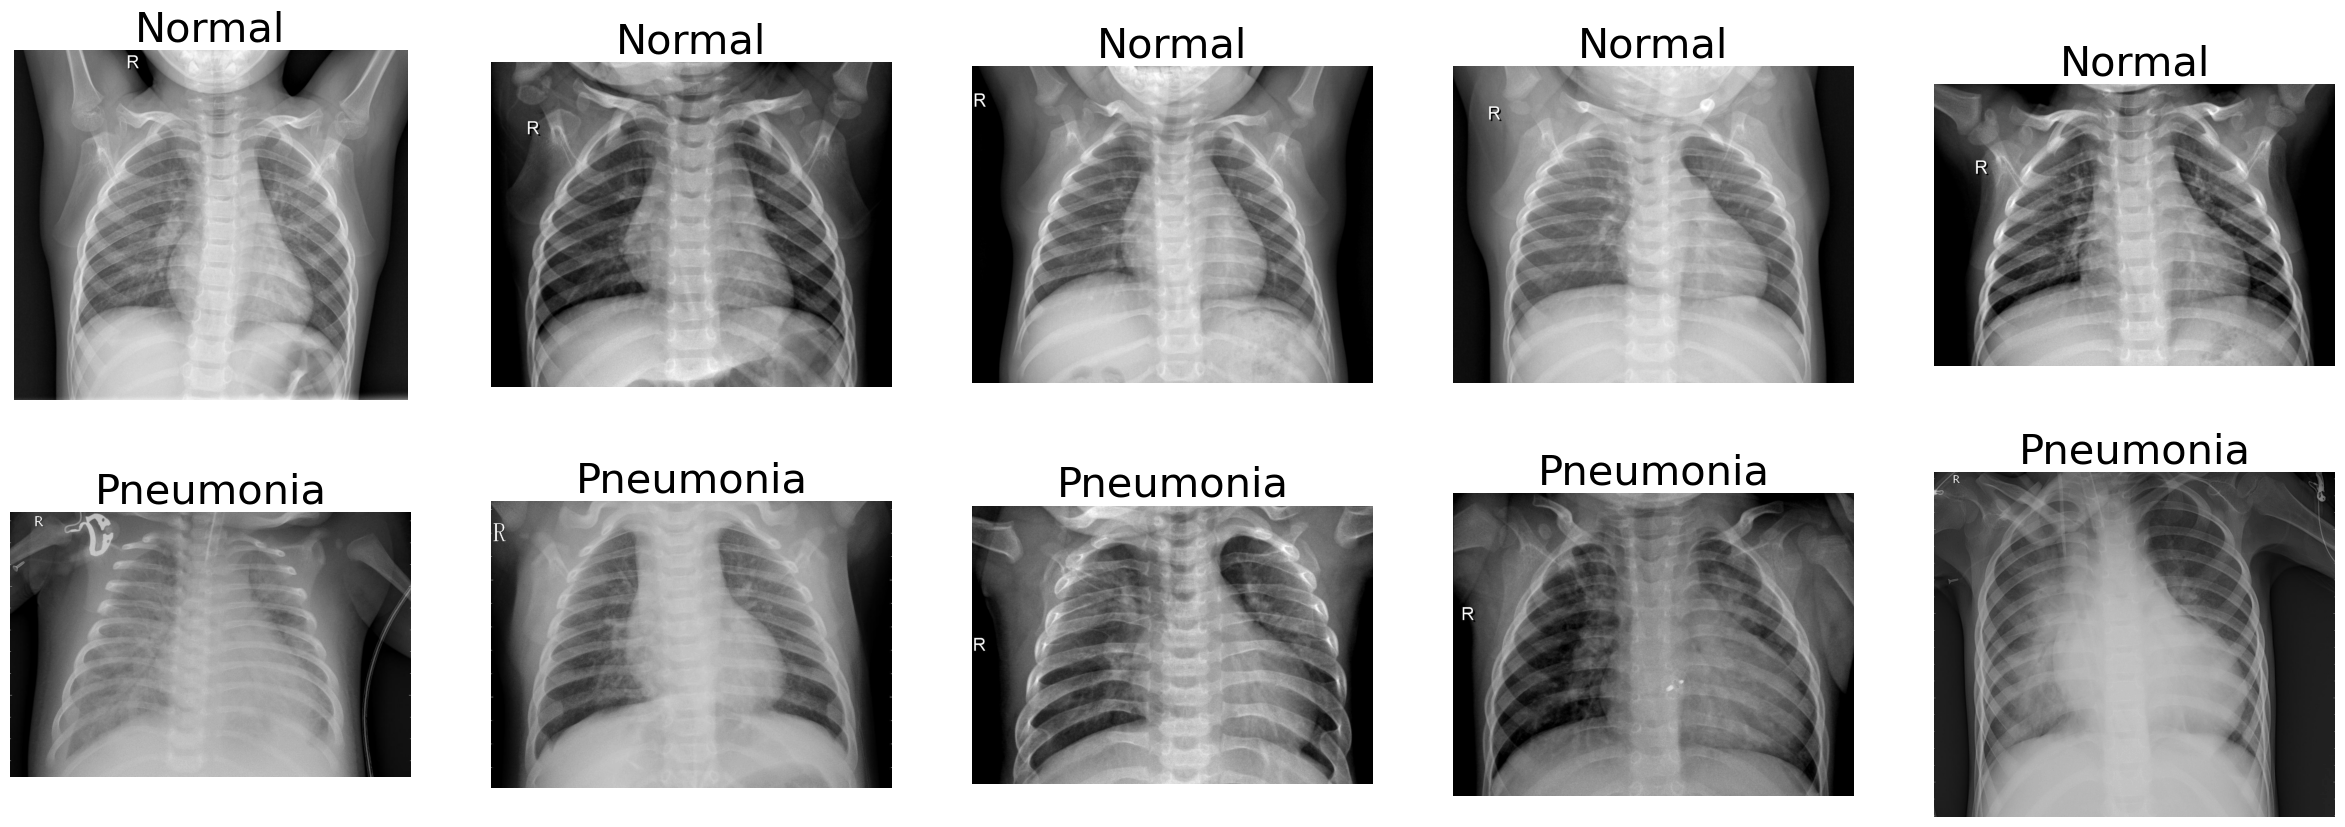

In [8]:
# see the sample images from normal and pneumonia training dataset
fig, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(0,5):
    img = plt.imread(os.path.join(train_normal_dir, os.listdir(train_normal_dir)[i]))
    ax[0,i].imshow(img, cmap='gray')
    ax[0,i].axis('off')
    ax[0,i].set_title('Normal', fontsize=30)
    
for i in range(0,5):
    img = plt.imread(os.path.join(train_pneumonia_dir, os.listdir(train_pneumonia_dir)[i]))
    ax[1,i].imshow(img, cmap='gray')
    ax[1,i].axis('off')
    ax[1,i].set_title('Pneumonia', fontsize=30)
    
plt.show()

In [46]:
# use data augmentation via Keras Image Data Generator

# scale the train and validation image into grayscale, shift the width and height and zoom the image a bit
train_datagen = image.ImageDataGenerator(rescale = 1.0/255, 
                                         samplewise_center=True, 
                                         samplewise_std_normalization=True, 
                                         zoom_range = 0.2, 
                                         width_shift_range=0.1,
                                         height_shift_range=0.1)

val_datagen  = image.ImageDataGenerator(rescale = 1.0/255, 
                                        samplewise_center=True, 
                                        samplewise_std_normalization=True, 
                                        zoom_range = 0.2, 
                                        width_shift_range=0.1,
                                        height_shift_range=0.1)

# scale the test image
test_datagen  = image.ImageDataGenerator(rescale = 1.0/255, 
                                         samplewise_center=True, 
                                         samplewise_std_normalization=True)

train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    batch_size=16, 
                                                    class_mode='binary', 
                                                    target_size=(160, 160))

val_generator = val_datagen.flow_from_directory(val_dir, 
                                                batch_size=16, 
                                                class_mode='binary',
                                                target_size=(160, 160))

test_generator = test_datagen.flow_from_directory(test_dir, 
                                                  class_mode='binary',
                                                  target_size=(160, 160))

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## 2. Machine Learning Model Training (Convolutional Neural Network)

In [47]:
# develop the convolutional neural network architecture
cnn = Sequential()

cnn.add(layers.InputLayer(input_shape=(160,160,3)))

cnn.add(layers.Conv2D(filters=32, kernel_size=(3, 3), padding='SAME'))
cnn.add(layers.BatchNormalization())
cnn.add(layers.Activation('relu'))
cnn.add(layers.MaxPool2D(pool_size=(2, 2)))

cnn.add(layers.Conv2D(filters=64, kernel_size=(3, 3), padding='SAME'))
cnn.add(layers.BatchNormalization())
cnn.add(layers.Activation('relu'))
cnn.add(layers.MaxPool2D(pool_size=(2, 2)))

cnn.add(layers.Conv2D(filters=128, kernel_size=(3, 3), padding='SAME'))
cnn.add(layers.BatchNormalization())
cnn.add(layers.Activation('relu'))
cnn.add(layers.MaxPool2D(pool_size=(2, 2)))

cnn.add(layers.Conv2D(filters=256, kernel_size=(3, 3), padding='SAME'))
cnn.add(layers.BatchNormalization())
cnn.add(layers.Activation('relu'))
cnn.add(layers.MaxPool2D(pool_size=(2, 2)))

cnn.add(layers.Conv2D(filters=512, kernel_size=(3, 3), padding='SAME'))
cnn.add(layers.BatchNormalization())
cnn.add(layers.Activation('relu'))
cnn.add(layers.MaxPool2D(pool_size=(2, 2)))

cnn.add(layers.Flatten())
cnn.add(layers.Dense(units=512, activation='relu'))
cnn.add(layers.Dense(units=1, activation='sigmoid'))

In [48]:
model_metric = ['accuracy', 
                metrics.Precision(name='precision'), 
                metrics.Recall(name='recall')]

cnn.compile(optimizer=optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=model_metric)

history = cnn.fit(train_generator, 
                  steps_per_epoch= train_no//16,
                  validation_data=val_generator,
                  epochs=15)

Epoch 1/15
326/326 [==============================] - 112s 340ms/step - loss: 0.8182 - accuracy: 0.8602 - precision: 0.9044 - recall: 0.9079 - val_loss: 6.5359 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/15
326/326 [==============================] - 112s 342ms/step - loss: 0.2099 - accuracy: 0.9220 - precision: 0.9437 - recall: 0.9517 - val_loss: 1.5856 - val_accuracy: 0.6250 - val_precision: 0.5714 - val_recall: 1.0000
Epoch 3/15
326/326 [==============================] - 112s 345ms/step - loss: 0.1606 - accuracy: 0.9411 - precision: 0.9603 - recall: 0.9605 - val_loss: 0.7734 - val_accuracy: 0.6250 - val_precision: 0.5714 - val_recall: 1.0000
Epoch 4/15
326/326 [==============================] - 111s 339ms/step - loss: 0.1434 - accuracy: 0.9456 - precision: 0.9614 - recall: 0.9654 - val_loss: 0.6007 - val_accuracy: 0.6875 - val_precision: 0.8000 - val_recall: 0.5000
Epoch 5/15
326/326 [==============================] - 111s 340ms/step - loss: 0.1314 - a

In [49]:
# see the model architecture
cnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 160, 160, 32)      896       
                                                                 
 batch_normalization_11 (Bat  (None, 160, 160, 32)     128       
 chNormalization)                                                
                                                                 
 activation_11 (Activation)  (None, 160, 160, 32)      0         
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 80, 80, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 80, 80, 64)        18496     
                                                                 
 batch_normalization_12 (Bat  (None, 80, 80, 64)      

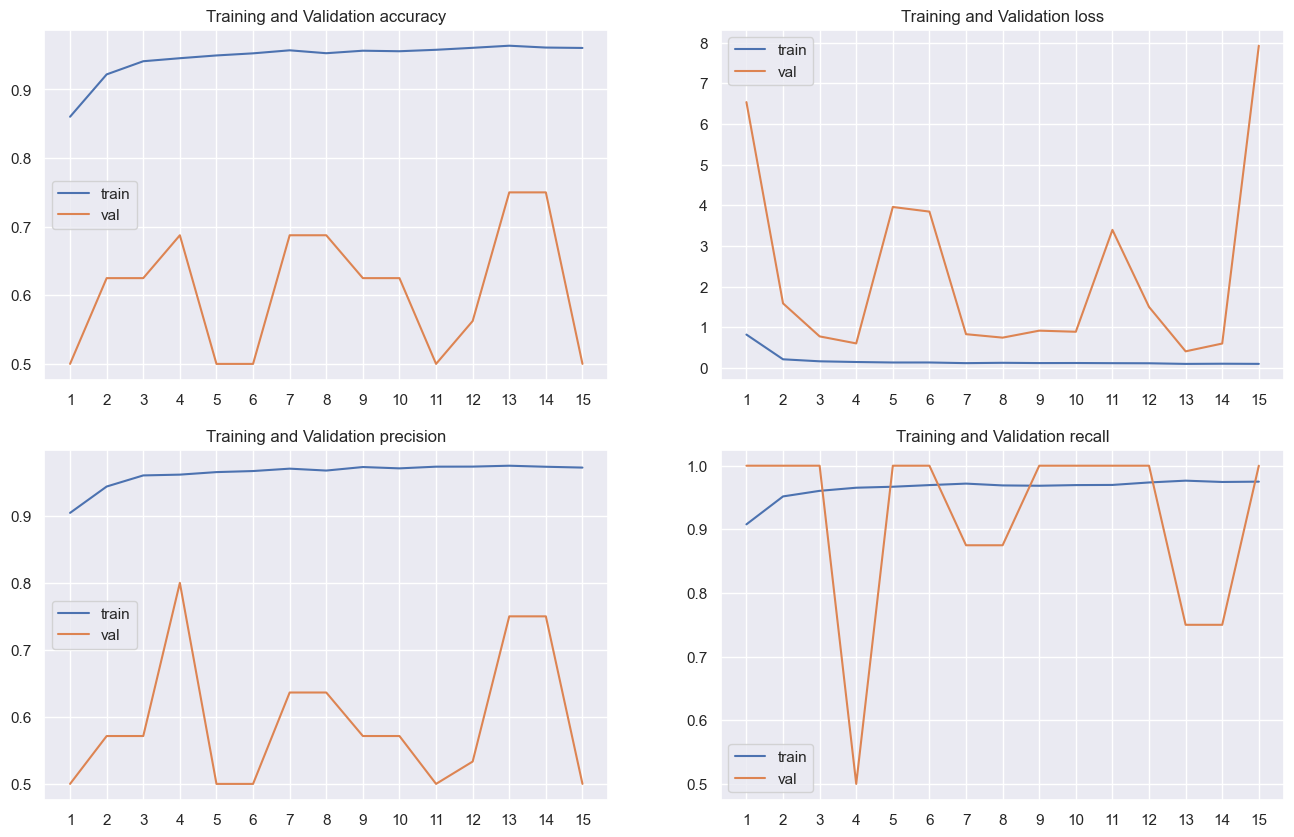

In [50]:
sns.set()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
precision = history.history['precision']
val_precision = history.history['val_precision']
recall = history.history['recall']
val_recall = history.history['val_recall']

epochs = range(1, len(acc)+1) 

def metrics_charts(epochs, train_metrics, val_metrics, title, i, j):
    # i and j are subplots location
    axes[i, j].plot(epochs, train_metrics, label='train')
    axes[i, j].plot(epochs, val_metrics, label='val')
    axes[i, j].set_xticks(np.arange(1, len(epochs)+1))
    axes[i, j].set_title('Training and Validation' + ' ' + title)
    axes[i, j].legend(['train', 'val'])
    return fig

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
metrics_charts(epochs, acc, val_acc, 'accuracy', 0, 0)
metrics_charts(epochs, loss, val_loss, 'loss', 0, 1)
metrics_charts(epochs, precision, val_precision, 'precision', 1, 0)
metrics_charts(epochs, recall, val_recall, 'recall', 1, 1)
plt.show()

As seen from the graph above, the validation loss is the lowest at epoch=4 before it bounce. Hence, epoch=4 is used to train the model.

In [52]:
cnn.fit(train_generator, 
          steps_per_epoch= train_no//16,
          validation_data=val_generator,
          epochs=4)

Epoch 1/4
326/326 [==============================] - 113s 347ms/step - loss: 0.0928 - accuracy: 0.9657 - precision: 0.9765 - recall: 0.9773 - val_loss: 1.4139 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/4
326/326 [==============================] - 112s 345ms/step - loss: 0.0934 - accuracy: 0.9655 - precision: 0.9758 - recall: 0.9778 - val_loss: 0.6105 - val_accuracy: 0.8125 - val_precision: 0.8571 - val_recall: 0.7500
Epoch 3/4
326/326 [==============================] - 108s 330ms/step - loss: 0.0904 - accuracy: 0.9678 - precision: 0.9786 - recall: 0.9781 - val_loss: 2.8764 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 4/4
326/326 [==============================] - 114s 350ms/step - loss: 0.0918 - accuracy: 0.9632 - precision: 0.9765 - recall: 0.9739 - val_loss: 0.8470 - val_accuracy: 0.6250 - val_precision: 0.5833 - val_recall: 0.8750


In [53]:
train_labels = []

for i in range(0, train_no//16):
    train_labels.extend(train_generator[i][1])
    
train_labels = np.array(train_labels)

train_preds = cnn.predict(train_generator)
train_preds = np.reshape(train_preds, train_no)

326/326 [==============================] - 111s 342ms/step


In [54]:
val_labels = []

for i in range(0, val_no//16):
    val_labels.extend(val_generator[i][1])
    
val_labels = np.array(val_labels)

val_preds = cnn.predict(val_generator)
val_preds = np.reshape(val_preds, val_no)

1/1 [==============================] - 0s 458ms/step


In [55]:
test_labels = []

for i in range(0, test_no//32+1):
    test_labels.extend(test_generator[i][1])
    
test_labels = np.array(test_labels)

test_preds = cnn.predict(test_generator)
test_preds = np.reshape(test_preds, test_no)

20/20 [==============================] - 8s 379ms/step


Text(0.5, 1.0, 'Training set')

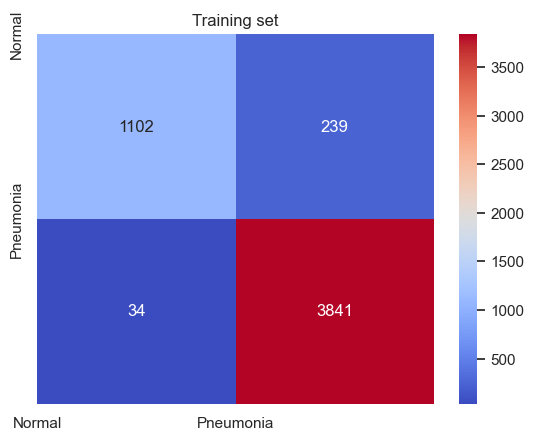

In [58]:
sns.heatmap(confusion_matrix(train_labels, np.where(train_preds>0.5, 1, 0)), annot=True, cmap='coolwarm', fmt=".0f")
plt.xticks(range(2), ['Normal', 'Pneumonia'])
plt.yticks(range(2), ['Normal', 'Pneumonia'])
plt.title('Training set')

In [63]:
print('Classification report for Training Set')
print(classification_report(train_labels, np.where(train_preds>0.5, 1, 0)))

Classification report for Training Set
              precision    recall  f1-score   support

         0.0       0.97      0.82      0.89      1341
         1.0       0.94      0.99      0.97      3875

    accuracy                           0.95      5216
   macro avg       0.96      0.91      0.93      5216
weighted avg       0.95      0.95      0.95      5216



Text(0.5, 1.0, 'Validation set')

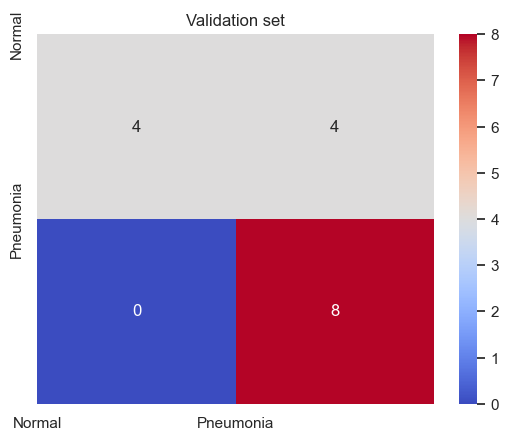

In [57]:
sns.heatmap(confusion_matrix(val_labels, np.where(val_preds>0.5, 1, 0)), annot=True, cmap='coolwarm', fmt=".0f")
plt.xticks(range(2), ['Normal', 'Pneumonia'])
plt.yticks(range(2), ['Normal', 'Pneumonia'])
plt.title('Validation set')

In [64]:
print('Classification report for Validation Set')
print(classification_report(val_labels, np.where(val_preds>0.5, 1, 0)))

Classification report for Validation Set
              precision    recall  f1-score   support

         0.0       1.00      0.50      0.67         8
         1.0       0.67      1.00      0.80         8

    accuracy                           0.75        16
   macro avg       0.83      0.75      0.73        16
weighted avg       0.83      0.75      0.73        16



Text(0.5, 1.0, 'Test set')

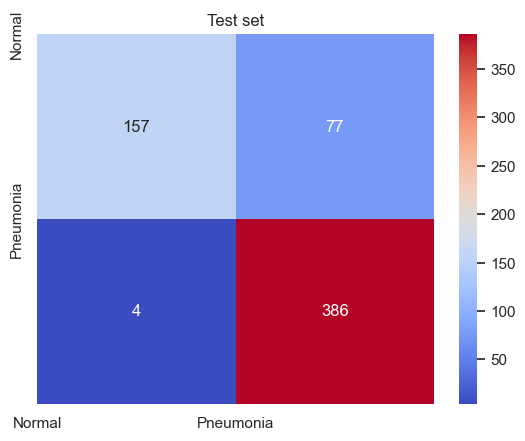

In [59]:
sns.heatmap(confusion_matrix(test_labels, np.where(test_preds>0.5, 1, 0)), annot=True, cmap='coolwarm', fmt=".0f")
plt.xticks(range(2), ['Normal', 'Pneumonia'])
plt.yticks(range(2), ['Normal', 'Pneumonia'])
plt.title('Test set')

In [65]:
print('Classification report for Test Set')
print(classification_report(test_labels, np.where(test_preds>0.5, 1, 0)))

Classification report for Test Set
              precision    recall  f1-score   support

         0.0       0.98      0.67      0.79       234
         1.0       0.83      0.99      0.91       390

    accuracy                           0.87       624
   macro avg       0.90      0.83      0.85       624
weighted avg       0.89      0.87      0.86       624



## Conclusion

The dataset is pretty imbalance with more normal classes.

The convolutional neural network performs not bad overall with f1 macro of 0.85.

The model can be improved further with more dataset from normal classes.

In [ ]:
def double_conv_block(x, n_filters):
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    return x

In [ ]:
def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)
    return f, p

In [ ]:
def upsample_block(x, conv_features, n_filters):
    # upsample
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    # concatenate
    x = layers.concatenate([x, conv_features])
    # dropout
    x = layers.Dropout(0.3)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)
    return x

In [ ]:
# inputs
inputs = layers.Input(shape=(160,160,3))

# encoder: contracting path - downsample
# 1 - downsample
f1, p1 = downsample_block(inputs, 64)

# 2 - downsample
f2, p2 = downsample_block(p1, 128)

# 3 - downsample
f3, p3 = downsample_block(p2, 256)

# 4 - downsample
f4, p4 = downsample_block(p3, 512)

# 5 - bottleneck
bottleneck = double_conv_block(p4, 1024)

# decoder: expanding path - upsample
# 6 - upsample
u6 = upsample_block(bottleneck, f4, 512)

# 7 - upsample
u7 = upsample_block(u6, f3, 256)

# 8 - upsample
u8 = upsample_block(u7, f2, 128)

# 9 - upsample
u9 = upsample_block(u8, f1, 64)

# outputs
fc1 = layers.Conv2D(1, (1, 1), padding="same", activation="relu") (u9)

fc12 = layers.MaxPool2D(pool_size=(2, 2)) (fc1)

fc2 = layers.Flatten() (fc12)

fc3 = layers.Dense(units=256, activation='relu') (fc2)

outputs = layers.Dense(units=1, activation='sigmoid') (fc3)

In [ ]:
unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

In [ ]:
model_metric = ['accuracy', 
                metrics.Precision(name='precision'), 
                metrics.Recall(name='recall')]

unet_model.compile(optimizer=optimizers.Adam(), 
                   loss=tf.keras.losses.BinaryCrossentropy(), 
                   metrics=model_metric)

In [ ]:
history_unet = unet_model.fit(train_generator, 
                              steps_per_epoch= train_no//8, 
                              validation_data=val_generator, 
                              epochs=10)

unet_model.summary()

In [ ]:
sns.set()

acc = unet_history.history['accuracy']
val_acc = unet_history.history['val_accuracy']
loss = unet_history.history['loss']
val_loss = unet_history.history['val_loss']
precision = unet_history.history['precision']
val_precision = unet_history.history['val_precision']
recall = unet_history.history['recall']
val_recall = unet_history.history['val_recall']

epochs = range(1, len(acc)+1) 

def metrics_charts(epochs, train_metrics, val_metrics, title, i, j):
    # i and j are subplots location
    axes[i, j].plot(epochs, train_metrics, label='train')
    axes[i, j].plot(epochs, val_metrics, label='val')
    axes[i, j].set_xticks(np.arange(1, len(epochs)+1))
    axes[i, j].set_title('Training and Validation' + ' ' + title)
    axes[i, j].legend(['train', 'val'])
    return fig

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
metrics_charts(epochs, acc, val_acc, 'accuracy', 0, 0)
metrics_charts(epochs, loss, val_loss, 'loss', 0, 1)
metrics_charts(epochs, precision, val_precision, 'precision', 1, 0)
metrics_charts(epochs, recall, val_recall, 'recall', 1, 1)
plt.show()